In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch.nn as nn


In [2]:
root_dir = "/kaggle/input/multiclassimagedatasetairplanecar/Dataset"

train_dir = os.path.join(root_dir, "train")
test_dir = os.path.join(root_dir, "test")

print(f"Train directory: {train_dir}")
print(f"Test directory: {test_dir}")


Train directory: /kaggle/input/multiclassimagedatasetairplanecar/Dataset/train
Test directory: /kaggle/input/multiclassimagedatasetairplanecar/Dataset/test


In [3]:
transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.229, 0.225])
])

In [4]:
train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(test_dir, transform=transform)

In [5]:
train_idx, val_idx = train_test_split(np.arange(len(train_dataset)), test_size=0.2, random_state=42)

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(train_dataset, batch_size=32, sampler=val_sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
model = torchvision.models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_f = model.fc.in_features

model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_f, 64),
    nn.ReLU(),
    nn.BatchNorm1d(64), 
    nn.Dropout(0.2),
    nn.Linear(64, 3)
)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 115MB/s] 


In [9]:
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.0001)

In [10]:
def train_model(model, criterion, optimizer, num_epochs=10):
    history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
    
    for ep in range(num_epochs):
        model.train()
        full_loss = 0.0
        full_corrects = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                loss.backward()
                optimizer.step()

                
            full_loss += loss.item()*inputs.size(0)
            full_corrects += torch.sum(preds==labels.data)
        ep_loss = full_loss / len(train_idx)
        ep_acc = full_corrects.double() / len(train_idx)
        
        history["train_loss"].append(ep_loss)
        history["train_acc"].append(ep_acc.item())
        
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds==labels.data)
                
        val_ep_loss = val_loss / len(val_idx)
        val_ep_acc = val_corrects.double() / len(val_idx)
        
        history["val_loss"].append(val_ep_loss)
        history["val_acc"].append(val_ep_acc.item())
        
        print(f'Epoch {ep+1}/{num_epochs} - '
              f'Train Loss: {ep_loss:.4f} Acc: {ep_acc:.4f} - '
              f'Val Loss: {val_ep_loss:.4f} Acc: {val_ep_acc:.4f}')
    return model, history
trained_model, history = train_model(model, criterion, optimizer, num_epochs=10)


Epoch 1/10 - Train Loss: 0.7530 Acc: 0.7033 - Val Loss: 0.3681 Acc: 0.9667
Epoch 2/10 - Train Loss: 0.3725 Acc: 0.9200 - Val Loss: 0.2191 Acc: 0.9817
Epoch 3/10 - Train Loss: 0.2421 Acc: 0.9571 - Val Loss: 0.1340 Acc: 0.9867
Epoch 4/10 - Train Loss: 0.1879 Acc: 0.9638 - Val Loss: 0.1075 Acc: 0.9917
Epoch 5/10 - Train Loss: 0.1496 Acc: 0.9742 - Val Loss: 0.0844 Acc: 0.9867
Epoch 6/10 - Train Loss: 0.1290 Acc: 0.9767 - Val Loss: 0.0703 Acc: 0.9950
Epoch 7/10 - Train Loss: 0.1100 Acc: 0.9829 - Val Loss: 0.0633 Acc: 0.9950
Epoch 8/10 - Train Loss: 0.1095 Acc: 0.9758 - Val Loss: 0.0562 Acc: 0.9917
Epoch 9/10 - Train Loss: 0.0972 Acc: 0.9779 - Val Loss: 0.0507 Acc: 0.9950
Epoch 10/10 - Train Loss: 0.0837 Acc: 0.9838 - Val Loss: 0.0483 Acc: 0.9900


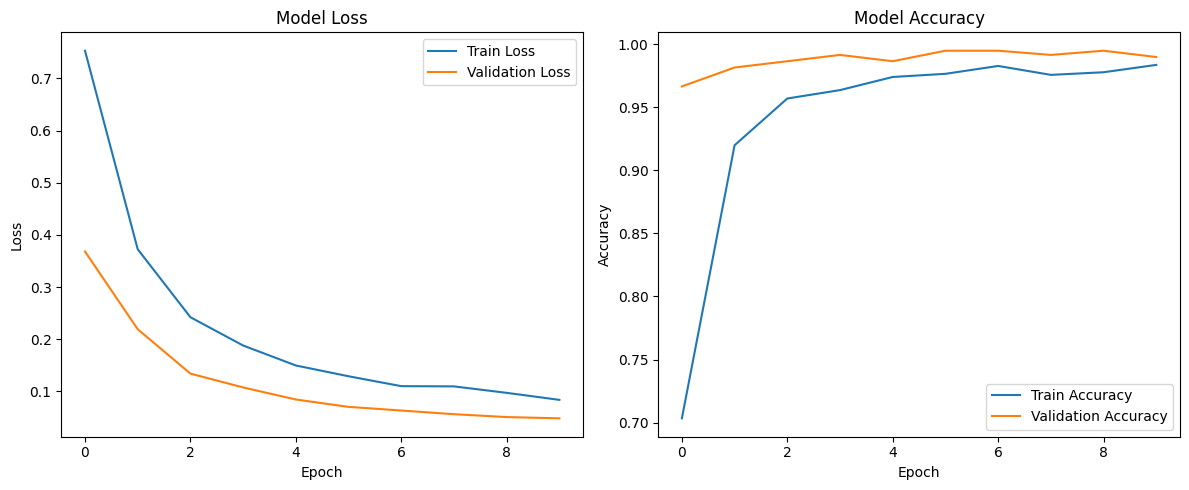


Анализ данных:
Количество тренировочных образцов: 2400
Количество валидационных образцов: 600
Количество тестовых образцов: 582

Распределение классов (тренировочный набор):
Класс airplanes: 1000 образцов
Класс cars: 1000 образцов
Класс ship: 1000 образцов


In [11]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print("\nАнализ данных:")
print(f"Количество тренировочных образцов: {len(train_idx)}")
print(f"Количество валидационных образцов: {len(val_idx)}")
print(f"Количество тестовых образцов: {len(test_dataset)}")
print("\nРаспределение классов (тренировочный набор):")
train_labels = [label for _, label in train_dataset.samples]
for i, count in enumerate(np.bincount(train_labels)):
    print(f"Класс {train_dataset.classes[i]}: {count} образцов")

In [12]:
np.mean(history["val_acc"])

0.9880000000000001

Train directory: /kaggle/input/multiclassimagedatasetairplanecar/Dataset/train
Test directory: /kaggle/input/multiclassimagedatasetairplanecar/Dataset/test
Epoch 1/10 - Train Loss: 0.8387 Acc: 0.6254 - Val Loss: 0.4118 Acc: 0.9633
Epoch 2/10 - Train Loss: 0.3955 Acc: 0.9104 - Val Loss: 0.2125 Acc: 0.9833
Epoch 3/10 - Train Loss: 0.2583 Acc: 0.9538 - Val Loss: 0.1452 Acc: 0.9883
Epoch 4/10 - Train Loss: 0.1997 Acc: 0.9638 - Val Loss: 0.1135 Acc: 0.9917
Epoch 5/10 - Train Loss: 0.1563 Acc: 0.9704 - Val Loss: 0.0955 Acc: 0.9933
Epoch 6/10 - Train Loss: 0.1339 Acc: 0.9758 - Val Loss: 0.0712 Acc: 0.9950
Epoch 7/10 - Train Loss: 0.1199 Acc: 0.9804 - Val Loss: 0.0627 Acc: 0.9950
Epoch 8/10 - Train Loss: 0.1098 Acc: 0.9800 - Val Loss: 0.0545 Acc: 0.9950
Epoch 9/10 - Train Loss: 0.0970 Acc: 0.9817 - Val Loss: 0.0570 Acc: 0.9917
Epoch 10/10 - Train Loss: 0.0855 Acc: 0.9854 - Val Loss: 0.0453 Acc: 0.9917


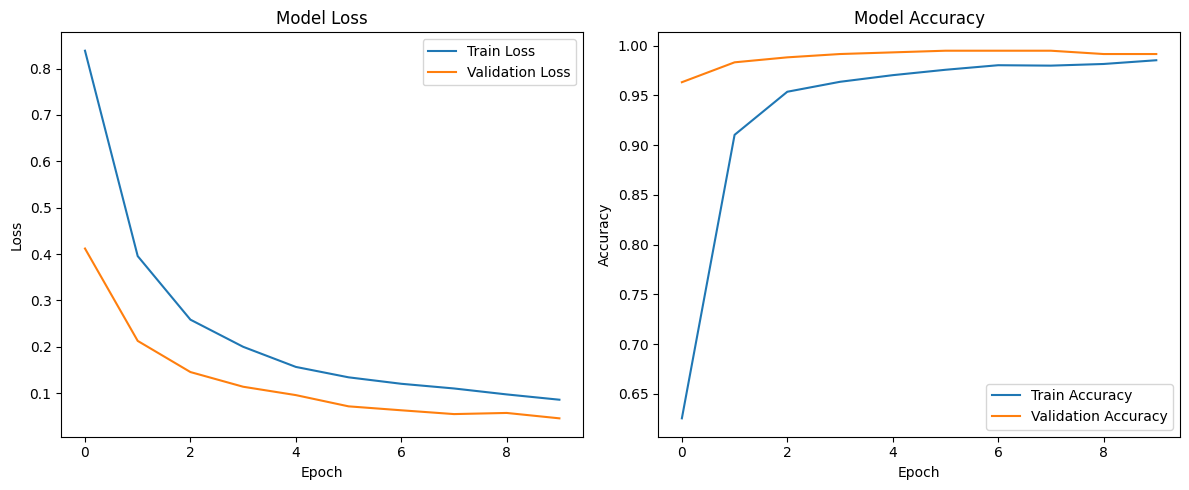


Анализ данных:
Количество тренировочных образцов: 2400
Количество валидационных образцов: 600
Количество тестовых образцов: 582

Распределение классов (тренировочный набор):
Класс airplanes: 1000 образцов
Класс cars: 1000 образцов
Класс ship: 1000 образцов


0.9888333333333333

In [13]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch.nn as nn
root_dir = "/kaggle/input/multiclassimagedatasetairplanecar/Dataset"

train_dir = os.path.join(root_dir, "train")
test_dir = os.path.join(root_dir, "test")

print(f"Train directory: {train_dir}")
print(f"Test directory: {test_dir}")
transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.229, 0.225])
])
train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(test_dir, transform=transform)
train_idx, val_idx = train_test_split(np.arange(len(train_dataset)), test_size=0.2, random_state=42)

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(train_dataset, batch_size=32, sampler=val_sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torchvision.models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_f = model.fc.in_features

model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_f, 64),
    nn.ReLU(),
    nn.BatchNorm1d(64), 
    nn.Dropout(0.2),
    nn.Linear(64, 3)
)
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.0001)
def train_model(model, criterion, optimizer, num_epochs=10):
    history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
    
    for ep in range(num_epochs):
        model.train()
        full_loss = 0.0
        full_corrects = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                loss.backward()
                optimizer.step()

                
            full_loss += loss.item()*inputs.size(0)
            full_corrects += torch.sum(preds==labels.data)
        ep_loss = full_loss / len(train_idx)
        ep_acc = full_corrects.double() / len(train_idx)
        
        history["train_loss"].append(ep_loss)
        history["train_acc"].append(ep_acc.item())
        
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds==labels.data)
                
        val_ep_loss = val_loss / len(val_idx)
        val_ep_acc = val_corrects.double() / len(val_idx)
        
        history["val_loss"].append(val_ep_loss)
        history["val_acc"].append(val_ep_acc.item())
        
        print(f'Epoch {ep+1}/{num_epochs} - '
              f'Train Loss: {ep_loss:.4f} Acc: {ep_acc:.4f} - '
              f'Val Loss: {val_ep_loss:.4f} Acc: {val_ep_acc:.4f}')
    return model, history
trained_model, history = train_model(model, criterion, optimizer, num_epochs=10)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print("\nАнализ данных:")
print(f"Количество тренировочных образцов: {len(train_idx)}")
print(f"Количество валидационных образцов: {len(val_idx)}")
print(f"Количество тестовых образцов: {len(test_dataset)}")
print("\nРаспределение классов (тренировочный набор):")
train_labels = [label for _, label in train_dataset.samples]
for i, count in enumerate(np.bincount(train_labels)):
    print(f"Класс {train_dataset.classes[i]}: {count} образцов")
    
np.mean(history["val_acc"])